In [1]:
# google.colab에 drive를 mount
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive//MyDrive/PDE'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1KgOE4_n0K-jHmJCGQUIQq6y3Bh7KWHwB/PDE


In [2]:
#optuna: hyperparameter 찾기에 좋은 library
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.3 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import optuna
import random


import matplotlib.pyplot as plt
import importlib
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
%reload_ext autoreload
from utils import *

# Utils functions

PDE Dimension(excluding t) : 2
Number of collocation points : 2500
x_min : -1
x_max : 1
test_x_grid_num : 20
y_min : -1
y_max : 1
test_y_grid_num : 20
t_max : 1
test_t_grid_num : 20
cha_num: 50
Number of boundary conditions: 4
Boundary for x or y? (x/y) : x
Boundary 1
Boundary1 : x = -1
Boundary 2
Boundary for x or y? (x/y) : x
Boundary2 : x = 1
Boundary 3
Boundary for x or y? (x/y) : y
Boundary3 : y = -1
Boundary 4
Boundary for x or y? (x/y) : y
Boundary4 : y = 1
boundary/initial points rato (%) : 20
torch.Size([500, 3])
Total sampled points : 5000


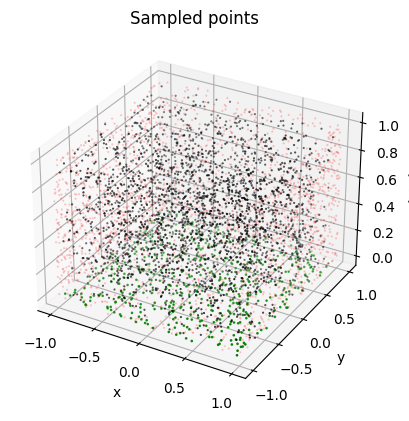

In [6]:
# point_sampler를 통해 다음 과정을 거침
# 1. points_dict: training에 사용할 점들을 random으로 sampling
# 2. test_dict: test에 이용할 점들을 uniform grid로 생성
# 3. points_dict_cha: characteristic_loss를 training시키기 위한 점들을 생성
points_dict, test_dict, points_dict_cha = point_sampler()
# collocation points: pde_loss학습에 필요한 sample 개수 생성
# _min, _max: 근사해를 구할 범위
# grid_num은 x,y,t축마다 test에 입력할 grid 격자점 개수
# cha_num: characteristic_loss를 학습시키기 위한 sample수
# Boundary/initial points ratio: sample*(변수%)로 Boundary/initial points 생성

In [7]:
#linear_condition: inviscid form 2D burger's equation에서 초기값을 u(x,y,0)=ax+by, v(x,y,0)=cx+dy라 했을 때의 상황
class linear_condition():
  def __init__(self,coef):
    self.a = coef[0]
    self.b = coef[1]
    self.c = coef[2]
    self.d = coef[3]
    self.D = self.a*self.d - self.b*self.c

  # analytic solution을 계산하는 함수
  def analytic_solution(self,batch):
    x = batch[:,0]
    y = batch[:,1]
    t = batch[:,2]

    denominator = self.D*(t**2) + (self.a+self.d)*t + 1

    u = (((self.D * t + self.a)*x + self.b * y)/denominator).unsqueeze(dim=-1)
    v = (((self.D * t + self.d)*y + self.c * x)/denominator).unsqueeze(dim=-1)

    result = torch.cat((u,v), dim=-1)

    return result

  # initial condition에 해당하는 u, v를 계산하는 함수
  def initial_condition(self,initial_points):
    return self.analytic_solution(initial_points)
  # boundary condition에 해당하는 u, v를 계산하는 함수
  def boundary_condition(self,boundary_points):
    return self.analytic_solution(boundary_points)


#known_condtion: analytic solution을 알고 있을 때의 상황, 나머지 함수들은 위와 동일한 기능을 함
class known_condition():

  def analytic_solution(self,batch):
    x = batch[:,0].unsqueeze(dim = -1)
    y = batch[:,1].unsqueeze(dim = -1)
    t = batch[:,2].unsqueeze(dim = -1)
    u =  torch.zeros_like(x)
    u[x<t]=2.
    v =  torch.zeros_like(x)

    result = torch.cat((u,v), dim=-1)

    return result

  def initial_condition(self,initial_points):
    return self.analytic_solution(initial_points)

  def boundary_condition(self,boundary_points):
    return self.analytic_solution(boundary_points)

#unknown_condtion: analytic solution을 모르고 있을 때의 상황, 나머지 함수들은 위와 동일한 기능을 함
class unknown_condition():

  def initial_condition(self,initial_points):
    x = initial_points[:,0].unsqueeze(dim = -1)
    y = initial_points[:,1].unsqueeze(dim = -1)
    t = initial_points[:,2].unsqueeze(dim = -1)

    initial_condition1 = None
    initial_condition2 = None

    return torch.cat((initial_condition1, initial_condition2), dim = -1)

  def boundary_condtion1(self,boundary_points):
    x = None
    y = None
    t = None

    boundary_condition1 = None
    boundary_condition2 = None

    return torch.cat((boundary_condition1, boundary_condition2), dim = -1)










In [8]:
# 위의 class에서 실제로 사용할 상황을 정의한 후, 객체 생성
condition = known_condition()

# Define dataset and network

In [9]:
class CustomDataset(Dataset):
  def __init__(self,col_x_y_t):
    self.col_x_y_t = col_x_y_t


  def __len__(self):
    return len(self.col_x_y_t)

  def __getitem__(self,idx):
    return self.col_x_y_t[idx]

In [19]:
# PINN model: linear layer, tanh 를 번갈아가며 반복하여 생성
def define_model(trial):
  layers = []
  input_dim = 3
  output_dim = 2
  features = 50
  num = 24
  layers.append(nn.Linear(input_dim, features))
  layers.append(nn.Tanh())
  for i in range(num-1):
    layers.append(nn.Linear(features, features))
    layers.append(nn.Tanh())

  layers.append(nn.Linear(features, output_dim))

  return nn.Sequential(*layers)

# Define loss function

In [20]:
def loss_fn(batch, model, points_dict, condition, device, loss_ratio):
# condition 수정할 땐 들어가야함
  # Loss metric
  mse = nn.MSELoss().to(device)

  # Forward
  batch = batch.requires_grad_(True).to(device)
  initial_points = points_dict['initial'].to(device)
  boundary_points = points_dict['boundary'].to(device)

  pde_out = model(batch)
  initial_out = model(initial_points)
  boundary_out = model(boundary_points)


  # First order partial derivative
  du = torch.autograd.grad(outputs = pde_out[:,0], inputs = batch, grad_outputs=torch.ones_like(pde_out[:,0]), create_graph = True)
  dv = torch.autograd.grad(outputs = pde_out[:,1], inputs = batch, grad_outputs=torch.ones_like(pde_out[:,1]), create_graph = True)

  u_x = du[0][:,0]
  u_y = du[0][:,1]
  u_t = du[0][:,2]

  v_x = dv[0][:,0]
  v_y = dv[0][:,1]
  v_t = dv[0][:,2]

  # Second order partial derivative
  u_xx = torch.autograd.grad(outputs = du[0][:,0], inputs = batch, grad_outputs = torch.ones_like(du[0][:,0]), create_graph = True)[0][:,0]
  u_yy = torch.autograd.grad(outputs = du[0][:,1], inputs = batch, grad_outputs = torch.ones_like(du[0][:,1]), create_graph = True)[0][:,1]

  v_xx = torch.autograd.grad(outputs = dv[0][:,0], inputs = batch, grad_outputs = torch.ones_like(dv[0][:,0]), create_graph = True)[0][:,0]
  v_yy = torch.autograd.grad(outputs = dv[0][:,1], inputs = batch, grad_outputs = torch.ones_like(dv[0][:,1]), create_graph = True)[0][:,1]

  # PDE loss

  nu = 0
  pde_u = u_t+pde_out[:,0]*u_x + pde_out[:,1]*u_y -nu*(u_xx+u_yy)
  pde_v = v_t + pde_out[:,0]*v_x + pde_out[:,1]*v_y- nu*(v_xx+v_yy)
  pde_loss = mse(pde_u, torch.zeros_like(pde_u)) + mse(pde_v, torch.zeros_like(pde_v))


  pde_loss_tensor = pde_u**2 + pde_v**2 # This is for RAR criteria

  # Initial condition loss
  initial_loss = mse(initial_out, condition.initial_condition(initial_points)) + mse(boundary_out, condition.boundary_condition(boundary_points))

  # Sum all losses
  total_loss = pde_loss * (1-loss_ratio) + initial_loss * loss_ratio

  return pde_loss, initial_loss, pde_loss_tensor, total_loss


In [21]:
# inviscid burger's equation에서는 모든 점마다 그 점을 지나는 characteristic line이 존재함
# smooth한 solution이 존재한다면 임의의 점 (x_0,y_0,t_0)에서의 해  u_0, v_0에 대해 u(u_0*(t-t_0)+x_0,v_0(t-t_0)+y_0,t_0)=u_0=u(x_0,y_0,t_0),
# v(u_0*(t-t_0)+x_0,v_0(t-t_0)+y_0,t_0)=v_0=v(x_0,y_0,z_0)임이 알려져 있다.
# 이에 착안하여 특정 sample 포인트에서, 그 점의 characteristic line들과 sample포인트에서 u,v값이 동일한 정도를 확인하는 characteristic_loss를 도입한다.
def cha_loss_fn(model, points_dict_cha, device):
  mse = nn.MSELoss().to(device)

  #sample 불러오기
  col_points_cha = points_dict_cha['collocation'].to(device)
  initial_points_cha = points_dict_cha['initial'].to(device)
  batch_total_col=torch.cat((col_points_cha,model(col_points_cha).detach()),dim=-1)
  batch_total_ini=torch.cat((initial_points_cha,model(initial_points_cha).detach()),dim=-1)


  # characteristic line 생성
  t_n = torch.linspace(0,1,50).repeat(50).to(device)

  x_n_col = (batch_total_col[:,3] * (t_n - batch_total_col[:,2]) + batch_total_col[:,0]).unsqueeze(dim = -1)
  y_n_col = (batch_total_col[:,4] * (t_n - batch_total_col[:,2]) + batch_total_col[:,1]).unsqueeze(dim = -1)

  x_n_ini = (batch_total_ini[:,3] * (t_n - batch_total_ini[:,2]) + batch_total_ini[:,0]).unsqueeze(dim = -1)
  y_n_ini = (batch_total_ini[:,4] * (t_n - batch_total_ini[:,2]) + batch_total_ini[:,1]).unsqueeze(dim = -1)

  newsample_col = torch.cat((x_n_col,y_n_col,t_n.unsqueeze(dim = -1)), dim = -1)
  newsample_ini = torch.cat((x_n_ini,y_n_ini,t_n.unsqueeze(dim = -1)), dim = -1)


  # sample point에서의 u, v
  real_value_col = batch_total_col[:,3:]
  real_value_ini = batch_total_ini[:,3:]

  #characteristic line에서의 u, v
  predict_col = model(newsample_col)
  predict_ini = model(newsample_ini)

  #mse로 initial/boundary points와 residual points(=collocation points)에서의 characteristic loss를 계산
  charac_loss_col = mse(real_value_col, predict_col)
  charac_loss_ini = mse(real_value_ini, predict_ini)
  return charac_loss_col, charac_loss_ini


In [22]:
def RAR(num,model,pde_loss, device, loss_ratio):
    # Collocation datapoints
    # num = 20000//(2**(epoch_cnt//100)) # Decreasing sampling points over epochs
    col_x_acce = torch.linspace(0, 0.5, num)[torch.randperm(num)].unsqueeze(dim = -1)
    col_y_acce = torch.linspace(0, 0.5, num)[torch.randperm(num)].unsqueeze(dim = -1)
    col_t_acce = torch.linspace(0, 0.7, num)[torch.randperm(num)].unsqueeze(dim = -1)

    col_acce = torch.cat((col_x_acce, col_y_acce, col_t_acce), dim = -1).requires_grad_(True).to(device)


    # PDE loss for new datapoints

    _,_,pde_loss_acce,_ = loss_fn(col_acce, model, points_dict, condition, device, loss_ratio)

    # Sample datapoints which pde loss is larger than given pde_loss
    criteria = pde_loss_acce - pde_loss
    sampled_col_points = col_acce[criteria > 0].detach()

    return sampled_col_points

# Train

1. define_model의 depth, feature 수
loss_fn에서 loss_ratio(initial_loss와 pde_loss와의 비율),
cha_loss_fn의 loss값들을 일정한 상수(loss_ratio_cha_col, loss_ratio_cha_ini)를 곱했을 때, 어떤 조건에서 모델의 성능이 좋은지 obtuna를 통해 hyperparameter tuning을 시행하였다.

 1000번 trial을 시행했었고, 구글 코랩 런타임 문제로 385번째 trial을 마치고 강제 종료되었다. 그때 성능이 가장 좋았던 값들이 각각
 (depth, feature, loss_ratio, loss_ratio_cha_col, loss_ratio_cha_ini)가 (24,50,0.8898925647995675, 0.4635169761847985, 0.6716815120903473)
(RAR은 적용하지 않았음: 'num_category' = 'zero')

2. 이후 RAR의 방법들 (zero, expotential, constant, fraction)에 대해 obtuna를 이용하여 테스트함. epcoh=20, 10번씩만 반복하였다.
시행 횟수가 적기에 함부로 말하기 어렵지만
RAR을 사용하지 않은 것보다 사용한 것이 좋은 성과를 나타내며
오히려 constant 보다 fraction, exponential이 좋은 성과를 나타내었다.
추후 많은 trial을 시도하여 확인하는 것 필요하다.
또한, RAR을 사용해서 얻은 sample수만큼 w/o RAR에서 추가로 더해서 비교하는 것이 옳은 방법이다. 추후 시행 예정
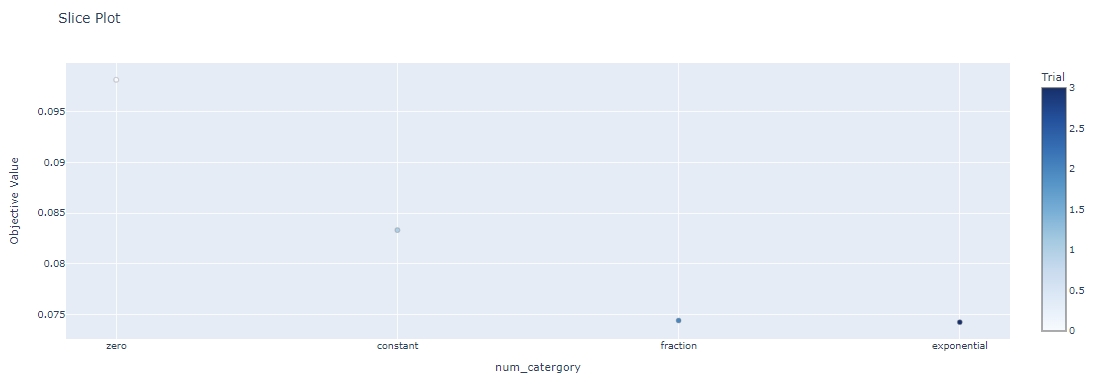

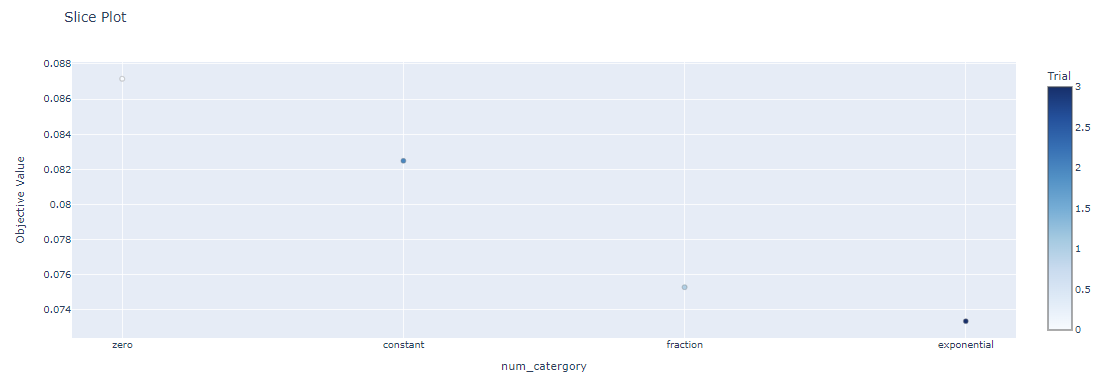

w/ RAR (num_category= 'exponential')을 적용하여 10000epoch로 학습하여 최종 model을 만들었다.

##  Adam

In [36]:
def objective(trial):
  device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
  num_epochs = 10000
  num_0 = 2500
  loss_ratio = 0.8898925647995675
  loss_ratio_cha_col= 0.4635169761847985
  loss_ratio_cha_ini= 0.6716815120903473
  num_category = trial.suggest_categorical("num_catergory", ['exponential'])
  cha_con = 3
  model = define_model(trial)
  model = model.to(device)
  optimizer = optim.Adam(model.parameters(), lr = 1E-4)
  col_x_y_t = points_dict['collocation']
  custom_dataset = CustomDataset(col_x_y_t)
  dataloader = DataLoader(custom_dataset, batch_size=512, shuffle = True)
  model.train()

  print(f'CURRENT_DEVICE : {device}')
  for epoch_cnt in range(1,num_epochs):
    if epoch_cnt % 1000 == 0:
      print(f'EPOCH {epoch_cnt}')
      total_loss = 0

      if num_category == "constant":
          num = num_0
      elif num_category == "fraction":
          num = (num_0)//(epoch_cnt//1000)
      elif num_category == "exponential":
          num = (2*num_0)//(2**(epoch_cnt//1000))
      if num_category != "zero":
        rar_loss,_,_,_ = loss_fn(test_dict['collocation'], model, test_dict, condition, device, loss_ratio)
        sampled_col_points = RAR(num, model, rar_loss, device, loss_ratio)
        print(f'NUMBER_OF_SAMPLED_POINTS : {sampled_col_points.shape[0]}')
        col_x_y_t = torch.cat((col_x_y_t.to(device), sampled_col_points), dim = 0)

        custom_dataset = CustomDataset(col_x_y_t)
        dataloader = DataLoader(custom_dataset, batch_size = 512, shuffle = True)


    for batch in dataloader:
      _,_,_,loss = loss_fn(batch, model,points_dict,condition,device,loss_ratio)

      if cha_con !=0:
        cha_loss_col, cha_loss_ini =cha_loss_fn(model, points_dict_cha, device)

      if cha_con ==1:
        loss += cha_loss_col
      elif cha_con ==2:
        loss += cha_loss_ini
      elif cha_con ==3:
        loss += loss_ratio_cha_col*cha_loss_col
        loss += loss_ratio_cha_ini*cha_loss_ini


      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if epoch_cnt % 1000 == 0:
        total_loss += loss.item()

    if epoch_cnt % 1000 == 0:
      print(f'LOSS : {total_loss}')
      validate_visualization(model, device, condition, observe_t = [0.0,0.2,0.4,0.6,0.8,1.0], x_range = [0.-1,1], y_range = [-1.0,1.0])
      torch.save(model, f'./pt/2D_BURGERS_EPOCH_{epoch_cnt}.pt')
  torch.save(model, './pt/2D_BURGERS_EPOCH_LAST_{remann}.pt')
  validate_visualization(model, device, condition, observe_t = [0.0,0.2,0.4,0.6,0.8,1.0], x_range = [0.-1,1], y_range = [-1.0,1.0])
  if cha_con != 0:
    print(cha_loss_fn(model, points_dict_cha, device))
  return real_test(test_dict, model, loss_ratio, loss_fn, condition, device)

In [ ]:
study=optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1)
study.best_params

In [ ]:
search_space={'num_catergory': ["zero","constant", "fraction", 'exponential']}
study=optuna.create_study(direction='minimize', sampler=optuna.samplers.GridSampler(search_space))
study.optimize(objective, n_trials=4)
study.best_params

In [35]:
optuna.visualization.plot_slice(study)

In [33]:
optuna.visualization.plot_slice(study)